In [1]:
import numpy as np
import os
from glob import glob
import pandas as pd
import itertools

from collections import OrderedDict
from tqdm.notebook import tqdm

# import pmi_accuracy.parser as parser
from pmi_accuracy.conll_data import CONLLReader, EXCLUDED_PUNCTUATION, CONLL_COLS
import sys
print(sys.path)

['/Users/j/McGill/PhD-miasma/pmi-dependencies', '/Users/j/anaconda3/envs/pmienv/lib/python37.zip', '/Users/j/anaconda3/envs/pmienv/lib/python3.7', '/Users/j/anaconda3/envs/pmienv/lib/python3.7/lib-dynload', '', '/Users/j/.local/lib/python3.7/site-packages', '/Users/j/anaconda3/envs/pmienv/lib/python3.7/site-packages', '/Users/j/anaconda3/envs/pmienv/lib/python3.7/site-packages/IPython/extensions', '/Users/j/.ipython']


In [110]:
plt.get_cmap("PuOr")(np.linspace(-1,3,2))

array([[0.49803922, 0.23137255, 0.03137255, 1.        ],
       [0.17647059, 0.        , 0.29411765, 1.        ]])

In [140]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1 import make_axes_locatable

def show_pmi_plot(sent, mat, gold, fig=None, ax=None, title=None):
    mat = np.nan_to_num(mat) # set nan to 0
    if np.min(mat) < 0:
        lim = max(abs(np.min(mat)), abs(np.max(mat)))
        cmap = 'PuOr'
        vmin, vcenter, vmax = -lim, 0, lim
    else:
        lim=np.max(mat)
        cmap = 'Purples'
        vmin, vcenter, vmax = 0, lim/2, lim
    if ax is None:
        fig, ax = plt.subplots()
    cax = ax.matshow(
        mat, cmap=cmap,
        norm=colors.TwoSlopeNorm(vcenter=vcenter, vmin=vmin, vmax=vmax))
    ###
    if gold.any():
        c=plt.get_cmap(cmap)(np.linspace(0, 1, 2))
        annotate_with_gold(
            cax, mat, goldmat=gold, threshold=vcenter, textcolors=[c[1],c[0]],
            mark='•', size=11, fontweight="bold")
    divider = make_axes_locatable(ax)
    cax1 = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(cax, cax=cax1)
    ax.xaxis.set_major_locator(ticker.FixedLocator(range(len(sent))))
    ax.yaxis.set_major_locator(ticker.FixedLocator(range(len(sent))))
    ax.xaxis.set_major_formatter(ticker.FixedFormatter(sent))
    ax.yaxis.set_major_formatter(ticker.FixedFormatter(sent))
    ax.tick_params(axis="x", labelrotation=40)
    ax.set_xlabel('w2 (masked/unmasked conditioner)')
    ax.set_ylabel('w1 (target)')
    ax.yaxis.set_label_position("left")
    if title is not None:
        ax.set_title(title, y=-.2)
    plt.setp(ax.get_xticklabels(), rotation=35,
             ha="left", rotation_mode="anchor")
    plt.setp(ax.get_yticklabels(), rotation=35,
             ha="right", rotation_mode="anchor")
    if ax is None:
        plt.show()
    
def plot_pmi_matrix(key_sen,pmi_matrix,gold,title=None):
    sentence = key_sen.split(' ')[1:]
    markings=np.random.randint(2,size=mat.shape)
    show_pmi_plot(sent=sentence, mat=pmi_matrix, gold=gold, title=title)

In [17]:
CONNLX_FILE = 'ptb3-wsj-data/ptb3-wsj-dev.conllx'
OBSERVATIONS = CONLLReader(CONLL_COLS).load_conll_dataset(CONNLX_FILE) #not necessary... just for checking
RESULTS_DIR = "results-clean/"

######
MATRICES = dict()
MODELS = [
    "bart-large",
    "bert-base-cased",
    # "bert-base-uncased_checkpointed",
    # "bert-base-uncased_pad30_2020-08-07-07-28",
    "bert-large-cased",
    "bert-large-uncased",
    "distilbert-base-cased",
    "gpt2",
    "w2v",
    "xlm",
    "xlnet-base-cased",
    "xlnet-large-cased"]
for m in MODELS:
    resultsdir = glob(os.path.join(
        RESULTS_DIR, "contextual_embedding_models",  m + '*/'))[0]
    npzpath = os.path.join(resultsdir, 'pmi_matrices.npz')
    MATRICES[m] = np.load(npzpath)

######  
POS_MATRICES = dict()
POS_MODELS = [
    ["IB_probe/", "IB_xpos_bert-large-cased"],
    ["IB_probe/", "IB_xpos_xlnet-base-cased"],
    ["simple_probe/", "xpos_bert-large-cased"],
    ["simple_probe/", "xpos_xlnet-base-cased"]
]
for pm in POS_MODELS:
    resultsdir = glob(os.path.join(
        RESULTS_DIR, "pos-cpmi", pm[0] + pm[1] + '*/'))[0]
    npzpath = os.path.join(resultsdir, 'pmi_matrices.npz')
    POS_MATRICES[pm[1]] = np.load(npzpath)

#######
LSTM_MATRICES = dict()
LSTM_MODELS = ["lstm", "onlstm", "onlstm_syd"]
for m in LSTM_MODELS:
    resultsdir = glob(os.path.join("lstm-vs-onlstm/",  m))[0]
    npzpath = os.path.join(resultsdir,'pmi_matrices.npz')
    LSTM_MATRICES[m] = np.load(npzpath)
    

{'lstm': <numpy.lib.npyio.NpzFile at 0x7fd33fb64a90>,
 'onlstm': <numpy.lib.npyio.NpzFile at 0x7fd33fb64590>,
 'onlstm_syd': <numpy.lib.npyio.NpzFile at 0x7fd33c1a83d0>}

AttributeError: 'NoneType' object has no attribute 'any'

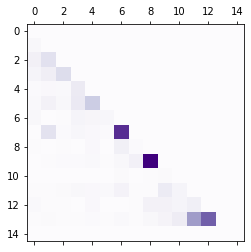

In [139]:
m = 'lstm'
for i in [1352]:
    key = list(LSTM_MATRICES[m].keys())[i]
    mat = LSTM_MATRICES[m][key]
    if not m == "w2v":
        mat = abs(mat)
    mat = np.nan_to_num(np.tril(mat + mat.T))
    plot_pmi_matrix(key, mat, title=m)
# plt.savefig('1352w2v.pdf')

In [41]:
def plot_comparison(selected_models, matrices, sentence_indices, save_suffix=None):
    for i in sentence_indices:
        # row of plots for sentence i
        figh = 5
        fig, axs = plt.subplots(
            nrows=1, sharex=True, ncols=len(selected_models),
            figsize=(len(selected_models)*figh,figh))
        for j,m in enumerate(selected_models):
            key = list(matrices[m].keys())[i]
            sentence = key.split(' ')[1:]
            mat = matrices[m][key]
            if m == "w2v":
                np.fill_diagonal(mat, 0)
            else:
                mat = abs(mat)
            mat = np.tril(mat + mat.T)
            show_pmi_plot(
                sentence, mat, fig=fig, ax=axs[j], 
                title=m)
        plt.subplots_adjust(wspace=.5)
        if save_suffix:
            plt.savefig(
                "figures/"+str(i)+save_suffix+".pdf",
                bbox_inches = 'tight')
    plt.show()

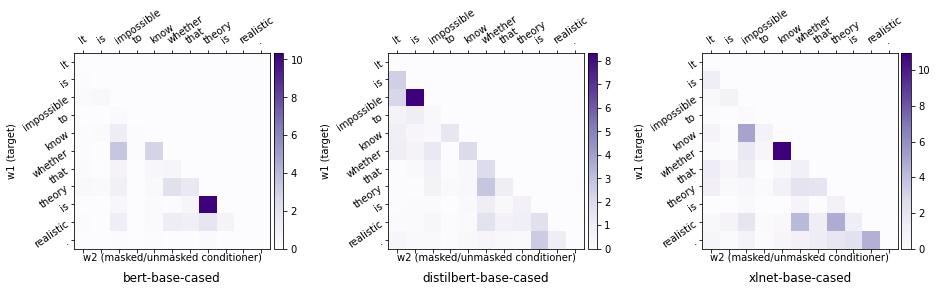

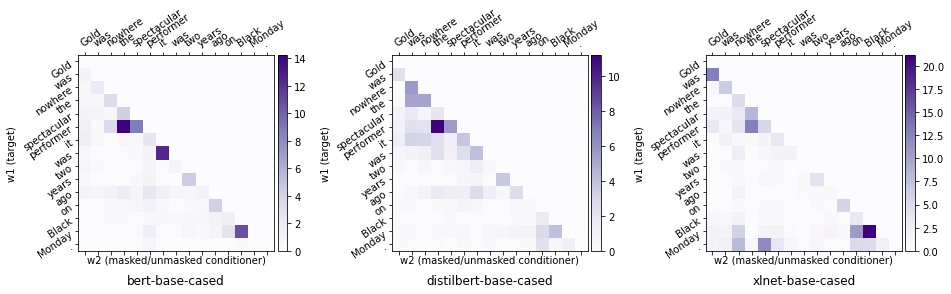

In [42]:
plot_comparison(
    ['bert-base-cased','distilbert-base-cased','xlnet-base-cased'], 
    MATRICES, [442,1352],
    save_suffix="ce")

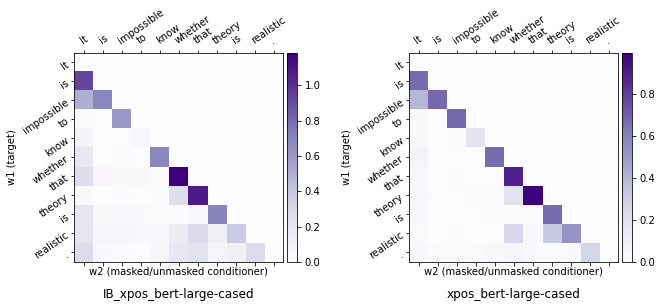

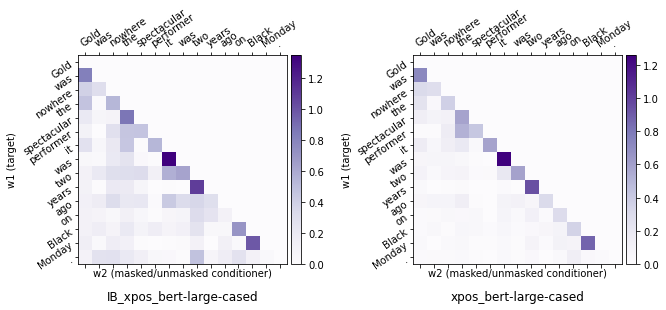

In [44]:
plot_comparison(
    ['IB_xpos_bert-large-cased','xpos_bert-large-cased'],
    POS_MATRICES, [442,1352],
    save_suffix="pos")

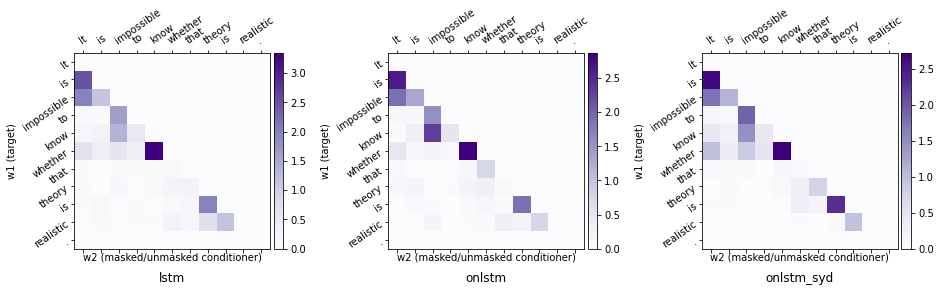

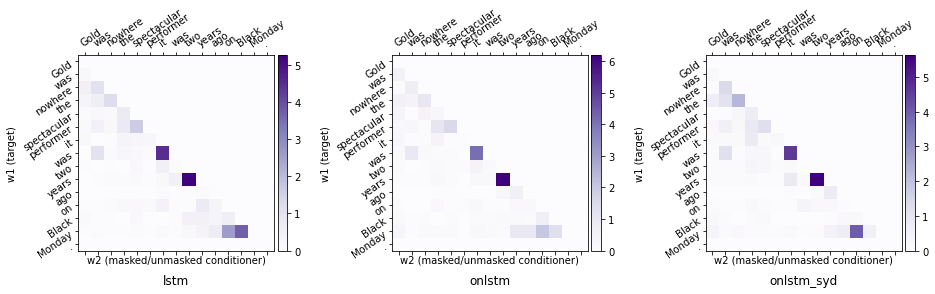

In [45]:
plot_comparison(
    ['lstm', 'onlstm', 'onlstm_syd'], 
    LSTM_MATRICES, [442,1352],
    save_suffix="lstm")

In [113]:
def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=["black", "white"],
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A list or array of two color specifications.  The first is used for
        values below a threshold, the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

def annotate_with_gold(
        im, mat, goldmat, mark="*", textcolors=['black','white'], threshold = 0, **textkw):
    data = goldmat
    kw = dict(horizontalalignment="center",
          verticalalignment="center")
    kw.update(textkw)
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            if data[i,j]:
                kw.update(color=textcolors[int(mat[i, j] > threshold)])
                text = im.axes.text(j, i, mark, **kw)
                texts.append(text)
    return texts